# ALIAS Target Selection

This notebook demonstrates the process used to select the initial dataset of approximately 1000 solar-type stars from the entire dataset of APOGEE spectra.

In [18]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

%matplotlib inline

The processes started with the `allStar-dr17-synspec_rev1.fits` file, which is publicly available from the SDSS [here](https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits).

This file contains measured properties of stars in the APOGEE catalogue and can be used to select the sample.

In [2]:
file = '../data/allStar-dr17-synspec_rev1.fits'

tbl = Table.read(file)

Stars with a signal-to-noise ratio (SNR) below `250` are excluded from the search.

In [3]:
snr_filter = tbl['SNR'] > 250
print('Num stars: %i' %sum(snr_filter))

Num stars: 170183


We now plot the remaining stars on a temperature versus surface gravity to visualize the remaining stars.

Since we are also looking for solar-type stars, we want to select for stars near the Sun on this plot, which is shown using the red box.

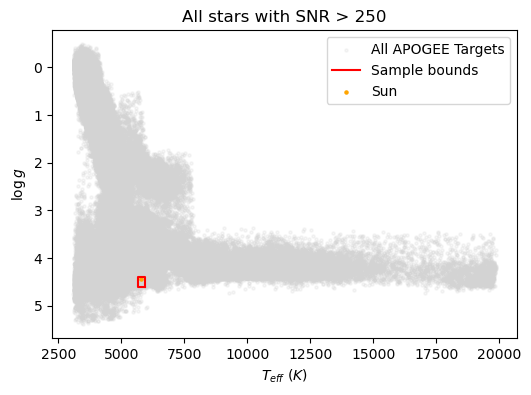

In [4]:
# Plot teff vs. logg 
_ = plt.figure(figsize=(6,4))
plt.title('All stars with SNR > 250')
plt.scatter(tbl['TEFF'], tbl['LOGG'], 
            s=5, alpha=0.2, label='All APOGEE Targets', color='lightgray')
plt.gca().invert_yaxis()

# Additionally, plot box used for selecting solar-type stars

# Parameters for selection box
teff = 5800
teff_spread = 150
logg = 4.5
logg_spread = 0.1

plt.plot([
        teff + teff_spread,
        teff + teff_spread,
        teff - teff_spread,
        teff - teff_spread,
        teff + teff_spread
    ], 
    [
        logg + logg_spread,
        logg - logg_spread,
        logg - logg_spread,
        logg + logg_spread,
        logg + logg_spread
    ], c='r', label='Sample bounds')
plt.scatter(5772,4.438, s=5, label='Sun', color='orange')
plt.xlabel('$T_{eff}$ ($K$)')
plt.ylabel('$\log g$')
plt.legend()
plt.savefig('teff_logg_all.png',dpi=150,bbox_inches='tight')

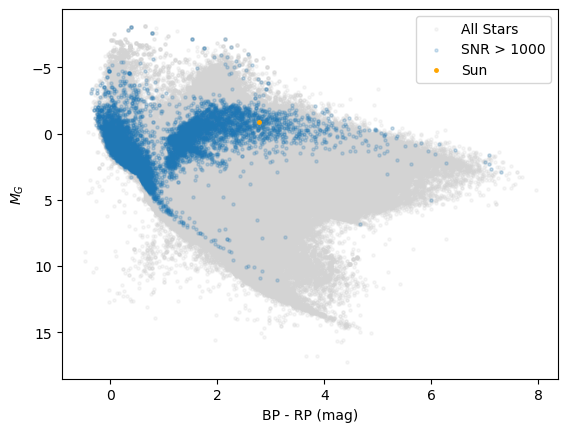

In [5]:
high_snr = tbl['SNR'] > 1000


plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'])+5, 
            s=5, color='lightgray', alpha=0.20, label='All Stars')
plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][high_snr] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][high_snr], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][high_snr] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][high_snr])+5, 
            s=5, alpha=0.20, label='SNR > 1000')

plt.plot(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][1] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][1], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][1] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][1])+5, 
            '.', ms=5, color='orange', label='Sun')

plt.gca().invert_yaxis()

plt.xlabel(r'BP - RP (mag)')
plt.ylabel(r'$M_G$')

plt.legend()

We can now select only stars in this box and ensure we have enough to make a sample of the desired size.

Note we also include a filter based on the BP and RP magnitude, since it was later determined that there were a few outliers in the aspect.

In [6]:
star_filter = np.array(
    (snr_filter) &
    (tbl['TEFF'] > teff - teff_spread) &
    (tbl['TEFF'] < teff + teff_spread) &
    (tbl['LOGG'] > logg - logg_spread) &
    (tbl['LOGG'] < logg + logg_spread) &
    (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] < 1.0 )
)

print('Num stars: %i' %sum(star_filter))

Num stars: 1254


1254 stars is plenty, so we can now plot these stars on the same temperature verses surface gravity diagram to make sure the selection worked as we expect.

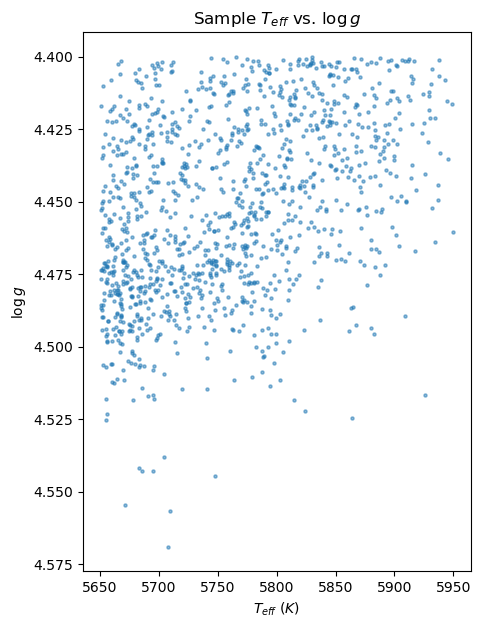

In [7]:
_ = plt.figure(figsize=(5,7))
plt.scatter(tbl['TEFF'][star_filter], tbl['LOGG'][star_filter], 
            s=5, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$T_{eff}$ ($K$)')
plt.ylabel('$\log g$')
plt.title('Sample $T_{eff}$ vs. $\log g$')
plt.savefig('teff_logg.png',dpi=150,bbox_inches='tight')

We can now plot these stars in a variety of other ways to make sure our sample is not significantly biased in any particular way.

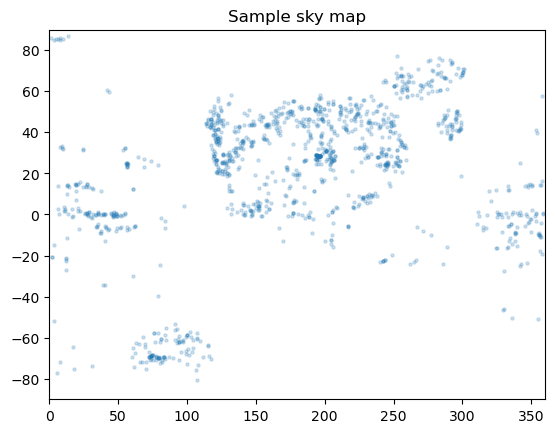

In [8]:
_ = plt.scatter(tbl['RA'][star_filter], tbl['DEC'][star_filter], s=5, alpha=0.2)
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.title('Sample sky map')
plt.savefig('skymap.png',dpi=150,bbox_inches='tight')

Here we also plot the bounds used in previous work to make sure our sample is not too different.

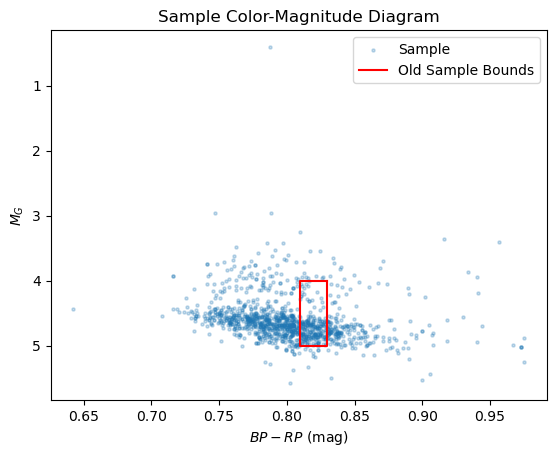

In [9]:
_ = plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][star_filter] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][star_filter], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][star_filter] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][star_filter])+5, 
            s=5, alpha=0.25, label='Sample')
plt.plot([0.82+0.01, 0.82+0.01, 0.82-0.01, 0.82-0.01, 0.82+0.01], [4,5,5,4,4], c='r', label='Old Sample Bounds')
plt.gca().invert_yaxis()
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel('$M_G$')
plt.legend()
plt.title('Sample Color-Magnitude Diagram')
plt.savefig('cmd.png',dpi=150,bbox_inches='tight')

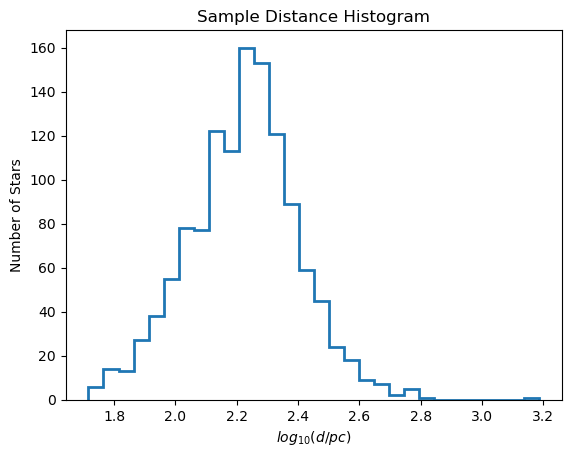

In [10]:
_ = plt.hist(np.log10(tbl['GAIAEDR3_R_LO_PHOTOGEO'][star_filter]),bins=30, lw=2, histtype='step')
plt.xlabel(r'$log_{10}(d/pc)$')
plt.ylabel('Number of Stars')
plt.title('Sample Distance Histogram')
plt.savefig('dist.png',dpi=150,bbox_inches='tight')

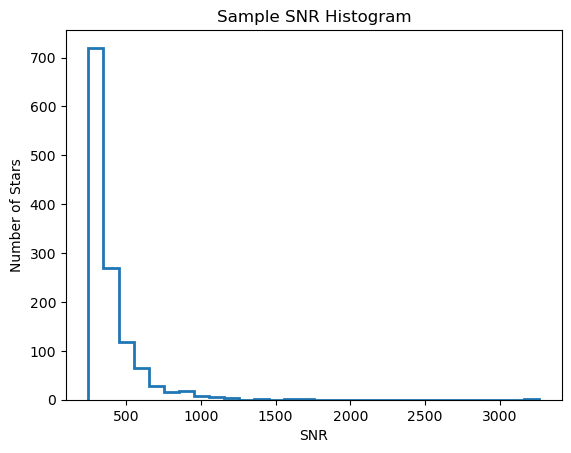

In [11]:
_ = plt.hist(tbl['SNR'][star_filter],bins=30, histtype='step', lw=2)
plt.xlabel('SNR')
plt.ylabel('Number of Stars')
plt.title('Sample SNR Histogram')
plt.savefig('snr.png',dpi=150,bbox_inches='tight')

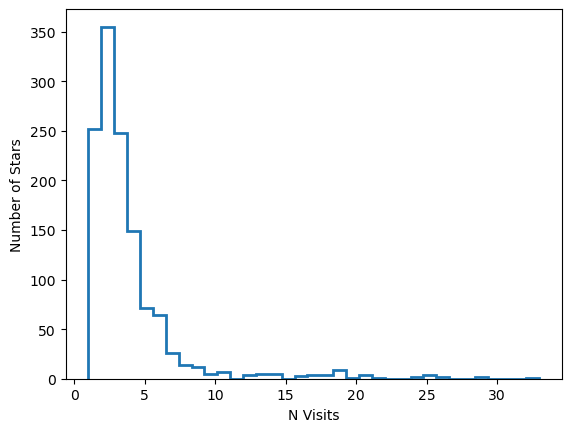

In [12]:
plt.hist(tbl['NVISITS'][star_filter],bins=35, histtype='step', lw=2)
plt.xlabel('N Visits')
_ = plt.ylabel('Number of Stars')
plt.savefig('nvisits.png',dpi=150,bbox_inches='tight')

Now that we are happy with our sample, we can construct urls for the stars' spectra and write them to a file.

In [13]:
telescopes = tbl['TELESCOPE'][star_filter]
fields = tbl['FIELD'][star_filter]
files = tbl['FILE'][star_filter]

urls = np.array(
    [
        'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/%s/%s/%s' %atts
        for atts in zip(telescopes, fields, files)
    ]
)

print('Files available: %i' %len(urls))

Files available: 1254


In [24]:
with open('../data/sample_star_urls_rev2', 'w') as f:
    for url in urls:
        f.write(url + '\n')

tbl[star_filter].write('../data/sample.fits')

This command will individually download each spectrum and place it in a directory:

In [ ]:
!xargs -a ../sample_star_urls_rev2 -d '\n' -n 1 -t curl -JO